# Final Inference for team 目前没啥思路(｡ì _ í｡)

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

## AE Pretrained GNN CNN

In [2]:
weight_aepgc  = 0.27625
sub1 = pd.read_csv('../input/24551-ae-gcn/submission(3).csv') # @sin lb 24551
sub2 = pd.read_csv('../input/hawkey-ae-pretrained-gcn-3ensemble/submission(4).csv') # @hawkey lb 248

## Non-pretrained RNN GCN

In [3]:
weight_nprg = 0.27625
sub3 = pd.read_csv('../input/gru-5fold-2seeds-knncv-68c7e1/submission.csv') # @ sin GRU cv 24393 forked from @ hrunic
sub4 = pd.read_csv('../input/fork-of-lstm-gru-5fold-2seeds-knncv-0a37d7/submission.csv') # @ sin GRU+LSTM cv 24176 forked from @ hrunic
sub5 = pd.read_csv('../input/lstm-5fold-2seeds-knncv-775f37/submission.csv') # @ sin LSTM cv 24376 forked from @ hrunic
sub6 = pd.read_csv('../input/hawkey-gcn-only-25301/submission(5).csv') # @ hawkey GCN lb 25301
sub7 = pd.read_csv('../input/wavenet-final/submission.csv') # @ sin Wavenet lb 258
sub8 = pd.read_csv('../input/wavenet2-moa/wavenet2_249.csv') # @ sin Wavenet lb 249

## With Aug Data

In [4]:
weight_aug = 0.0975
sub9 = pd.read_csv('../input/aug-data-local-training-gru-lstm/aug_data_training_local.csv') # @ sin cv 2345

## AE Pretrained Transformer

In [5]:
weight_pt = 0.35
sub10 = pd.read_csv('../input/open-vaccine-pytorch-pretrain/submission.csv') # @yirun zhang lb 2420
sub11 = pd.read_csv('../input/4-ae-pretrained-sin/submission_4_ae.csv') # @sin lb2448

## Blend of Public Notebooks

In [6]:
sub12 = pd.read_csv('../input/blend-of-public/blend_of_public.csv') # @ public

## Arrange Indices and Columns

In [7]:
final = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv').set_index('id_seqpos')
sample_sub = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')

In [8]:
sub1 = sub1[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub2 = sub2[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub3 = sub3[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub4 = sub4[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub5 = sub5[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub6 = sub6[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub7 = sub7[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub8 = sub8[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub9 = sub9[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub10 = sub10[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub11 = sub11[sample_sub.columns].set_index('id_seqpos').loc[final.index]
sub12 = sub12[sample_sub.columns].set_index('id_seqpos').loc[final.index]

## Final Blending

In [9]:
final = ((sub1 + sub2) / 2 * weight_aepgc + ((sub3 + sub4 + sub5 + sub6 + sub7) / 5 * 0.85 + sub8 * 0.15) * weight_nprg + sub9 * weight_aug + (sub10 * 0.7 + sub11 * 0.3) * weight_pt) * .93 + sub12 * .07

Here LB: 23777

## Analysis of our final submission

In [10]:
## get training labels
train = pd.read_json('../input/stanford-covid-vaccine/train.json', lines=True)
## filter noisy labels
train = train.query('signal_to_noise >= 1')
assert train.sequence.apply(len).tolist() == [107]*len(train)
train_reac = np.zeros(68)
train_mg50c = np.zeros(68)
train_mgph10 = np.zeros(68)
for a,b,c in zip(train.reactivity, train.deg_Mg_50C, train.deg_pH10):
    train_reac += np.array(a) /len(train)
    train_mg50c += np.array(b) /len(train)
    train_mgph10 += np.array(c) /len(train)

In [11]:
final_pp = final.copy().reset_index()
final_pp[['nothing', 'id','time']] = final_pp.id_seqpos.str.split('_', expand=True)
final_pp.time = final_pp.time.astype(int)
grouped = final_pp.query("time <= 106").groupby(['id','time']).mean()
reactivity = np.zeros(107)
dmph10 = np.zeros(107)
dm50c = np.zeros(107)
n = len(final_pp.id.unique())
for i in final_pp.id.unique():
    reactivity += grouped.loc[i].reactivity / n
    dmph10 += grouped.loc[i].deg_Mg_pH10 / n
    dm50c += grouped.loc[i].deg_Mg_50C / n

In [12]:
def plot_sub(title, sub, train_label):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(sub,  marker='.', label='Our Final Submission', c='blue')
    ax.plot(train_label, label= 'Training Label',  marker='.', c='red')
    ax.plot([67, 67], [0,1.5], linestyle=':', c='0.1')
    ax.plot([90, 90], [0,1.5], linestyle=':', c='0.1')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(np.arange(0,120, 5))
    ax.margins(x=.02,y=0)
    plt.title(title)
    plt.legend()

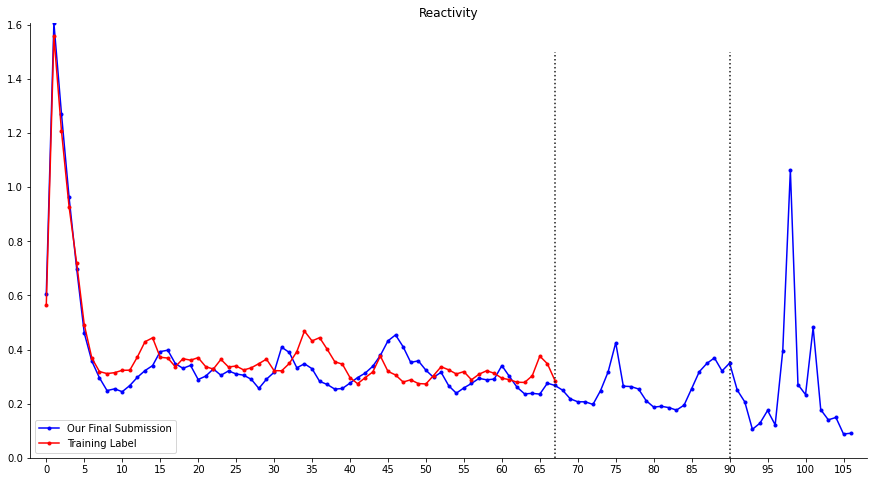

In [13]:
plot_sub('Reactivity', reactivity, train_reac)

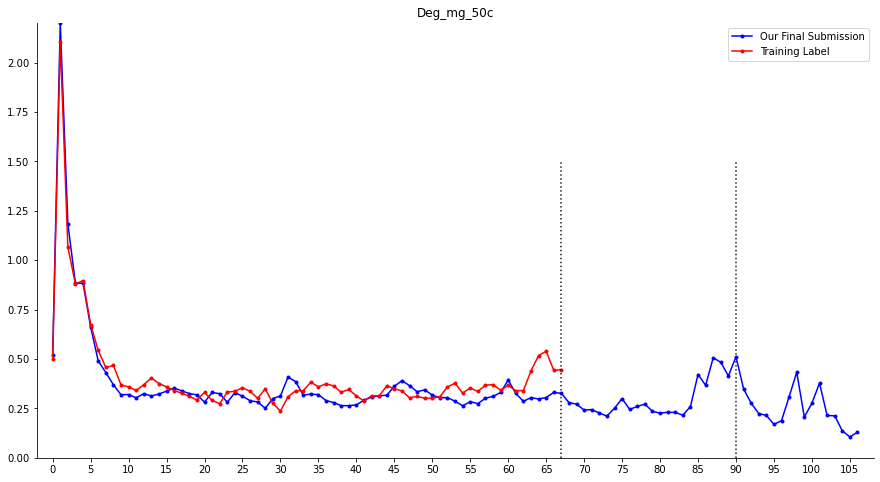

In [14]:
plot_sub('Deg_mg_50c', dm50c, train_mg50c)

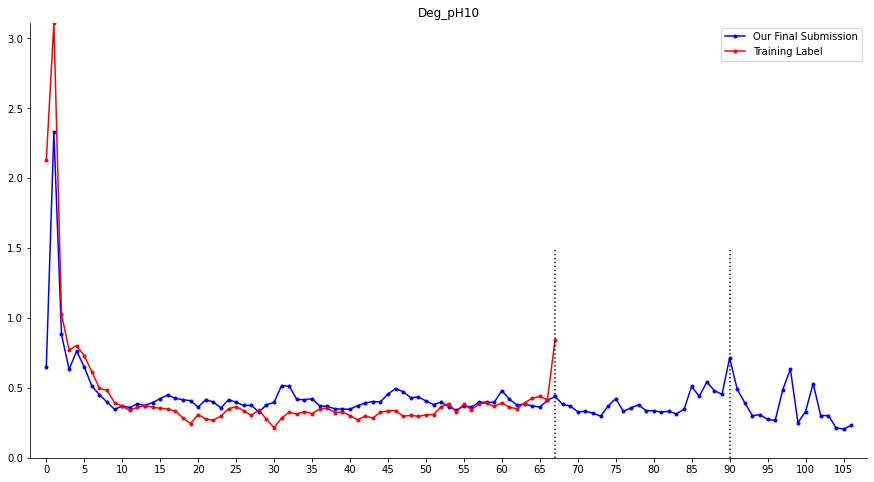

In [15]:
plot_sub('Deg_pH10', dmph10, train_mgph10)

## Post Processing

Mainly for private LB as we don't even have data for 68 + sequence. It's worth a bet. 

In [16]:
## deg_Mg_pH10 pp
final_pped = final_pp.copy()
final_pped.loc[(final_pped.time >= 14) & (final_pped.time <= 26), 'deg_Mg_pH10'] *= 0.9
final_pped.loc[(final_pped.time >= 41) & (final_pped.time <= 52), 'deg_Mg_pH10'] *= 0.9
final_pped.loc[(final_pped.time >= 30) & (final_pped.time <= 35), 'deg_Mg_pH10'] *= 0.9
final_pped.loc[(final_pped.time >= 67) & (final_pped.time <= 85), 'deg_Mg_pH10'] *= 0.9

## reactivity pp
final_pped.loc[(final_pped.time >= 8) & (final_pped.time <= 14), 'reactivity'] *= 0.9
final_pped.loc[(final_pped.time >= 33) & (final_pped.time <= 39), 'reactivity'] *= 0.9
final_pped.loc[(final_pped.time >= 45) & (final_pped.time <= 50), 'reactivity'] *= 0.9
final_pped.loc[(final_pped.time >= 74) & (final_pped.time <= 76), 'reactivity'] *= 0.9
final_pped.loc[final_pped.time >= 88, 'reactivity'] *= 0.9

## deg_Mg_50C pp
final_pped.loc[(final_pped.time >= 62) & (final_pped.time <=83) , 'deg_Mg_50C'] *= 0.9
final_pped.loc[(final_pped.time >= 83), 'deg_Mg_50C'] *= 0.9
final_pped.loc[(final_pped.time >= 52) & (final_pped.time <=57), 'deg_Mg_50C'] *= 0.9

In [17]:
grouped = final_pped.query("time <= 106").groupby(['id','time']).mean()
reactivity_pp = np.zeros(107)
dmph10_pp = np.zeros(107)
dm50c_pp = np.zeros(107)
n = len(final_pped.id.unique())
for i in final_pped.id.unique():
    reactivity_pp += grouped.loc[i].reactivity / n
    dmph10_pp += grouped.loc[i].deg_Mg_pH10 / n
    dm50c_pp += grouped.loc[i].deg_Mg_50C / n

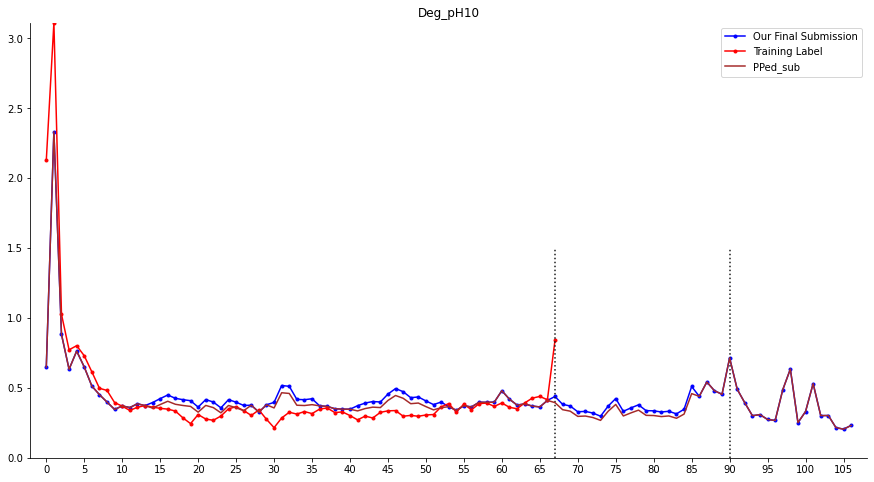

In [18]:
plot_sub('Deg_pH10', dmph10, train_mgph10)
plt.plot(dmph10_pp, c='brown', label='PPed_sub');
plt.legend();

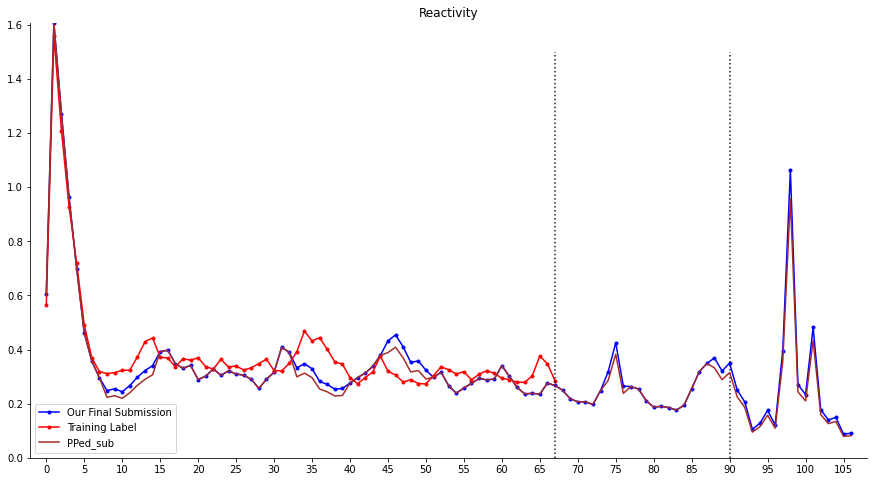

In [19]:
plot_sub('Reactivity', reactivity, train_reac)
plt.plot(reactivity_pp, c='brown', label='PPed_sub');
plt.legend();

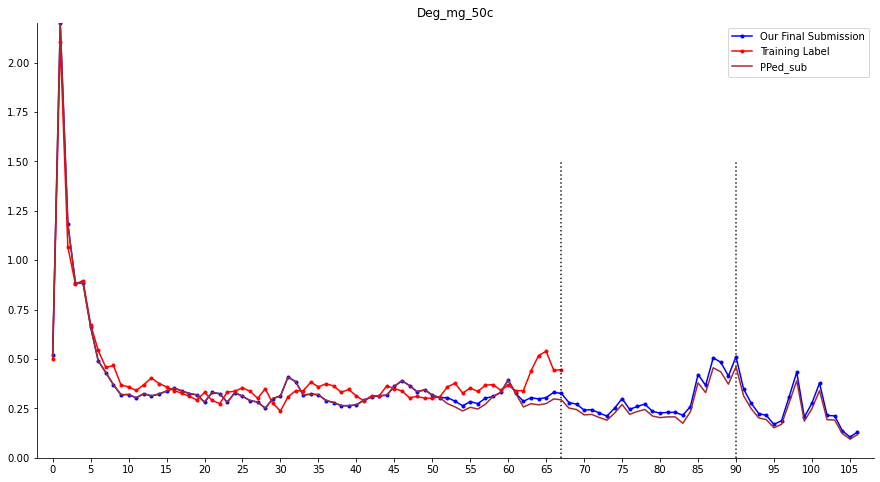

In [20]:
plot_sub('Deg_mg_50c', dm50c, train_mg50c)
plt.plot(dm50c_pp, c='brown', label='PPed_sub');
plt.legend();

In [21]:
final_pped.iloc[:, :-3].to_csv('final_pp.csv', index=False)